# DYNAMIC 2D-BUILDING ANALYSIS(GRAVITY-MODAL-PUSHOVER-TIMEHISTORY)

# IMPORT LIBRARIES

In [1]:
#%matplotlib inline

import openseespy.opensees as op
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import opsvis as ovs
import time
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 400

# Units Conversion

In [3]:
m=1.
mm=0.001*m
sec = 1.

KN = 1.
g = 9.81*(m/sec**2)  # gravity
ton = KN*(sec**2)/m   #mass

Pa = 0.001*(KN/m**2)
MPa = 10**6*Pa
GPa=10**9*Pa 

# Material Properties

In [5]:
#Concrete
fpc1 = -25.0*MPa  #Compressive Strength for unconfined concrete
fpc2 = -28.0*MPa  #Compressive Strength for confined concrete 
epsc0= -0.002 #Concrete Strain at maximum strength
fpcu1= 0.2*fpc1 #Crushing Strength
fpcu2= 0.2*fpc2 #Crushing Strength
epsu= -0.02#Strain at crushing Strength
lam = 0.1
ft1 = -0.1*fpc1
ft2 = -0.1*fpc2
Ets1 = (-0.1*fpc1)/0.002
Ets2 = (-0.1*fpc2)/0.002

#Steel
fy=  420.0*MPa #yield strength
E0= 210.0*GPa#initial elastic tangent
b= 0.005#strain-hardening ratio
R0 = 20.0
cR1 = 0.925
cR2 = 0.15

# Sections Dimensions

In [7]:
cover = 40*mm

# Beam section
H_b = 600*mm
B_b = 300*mm

#Column Section
H_c = 400*mm
B_c = 300*mm


#diameter of steel
dia = 25*mm
rebar_area = 0.25*np.pi*(dia**2)

# Section Builder Function

In [9]:
def build_rect_section(h, w, cov, secTag, coreTag, coverTag,steelTag,
                       core_fibY, core_fibZ, cov_fibY, cov_fibZ,rebar_area):
        
    vertices_core = np.array([cov-h/2, w/2-cov, h/2-cov, cov-w/2])
    vertices_top = np.array([h/2-cov, w/2-cov,  #bottom left
                             h/2-cov, cov-w/2,  #bottom right
                             h/2, -w/2,         #top right
                             h/2, w/2           #top left
                            ])
    vertices_bot = np.array([-h/2, w/2,
                             -h/2, -w/2,
                             cov-h/2, cov-w/2,
                             cov-h/2,w/2-cov
                            ])
    vertices_left = np.array([-h/2, w/2,
                              cov-h/2, w/2-cov,
                              h/2 -cov, w/2-cov,
                              h/2, w/2
                             ])
    vertices_right = np.array([cov-h/2, cov-w/2,
                               -h/2, -w/2,
                               h/2, -w/2,
                               h/2-cov, cov-w/2
                              ])

    #Creating concrete fiber
    op.section('Fiber', secTag, '-GJ', 1.0e9)
    
    #patch('rect', matTag, numSubdivY, numSubdivZ, *crdsI, *crdsJ)
    op.patch('rect', coreTag, core_fibY, core_fibZ, *vertices_core)   
    #patch('quad', matTag, numSubdivIJ, numSubdivJK, *crdsI, *crdsJ, *crdsK, *crdsL)
    op.patch('quad', coverTag, cov_fibZ, cov_fibY, *vertices_top)
    op.patch('quad', coverTag, cov_fibZ, cov_fibY, *vertices_bot)
    op.patch('quad', coverTag, cov_fibZ, cov_fibY, *vertices_left)
    op.patch('quad', coverTag, cov_fibZ, cov_fibY, *vertices_right)

    #layer('straight', matTag, numFiber, areaFiber, *start, *end)
    op.layer('straight', steelTag, 4, rebar_area, *[h/2-cov, w/2-cov], *[cov-h/2, w/2-cov])
    op.layer('straight', steelTag, 2, rebar_area, *[h/2-cov, 0], *[cov-h/2, 0])
    op.layer('straight', steelTag, 4, rebar_area, *[h/2-cov, cov-w/2], *[cov-h/2, cov-w/2])

# Model Builder Function

In [11]:
'''
Modify the function according to the number of bays
For example: 2 bays : Lx1,Lx2
             3 bays : Lx1,Lx2,Lx3
             4 bays : Lx1,Lx2,Lx3,Lx4
             .
             .
             .
'''

def build_model(Lx1,Lx2,Lx3,Lx4,Lz,no_of_bays, no_of_floors):  
    
    op.wipe()                                          
    op.model('basic', '-ndm', 2, '-ndf', 3)
    
    op.uniaxialMaterial('Concrete02', 1, fpc1, epsc0, fpcu1, epsu, lam, ft1, Ets1) #Unconfined Concrete
    op.uniaxialMaterial('Concrete02', 2, fpc2, epsc0, fpcu2, epsu, lam, ft2, Ets2) #Confined Concrete
    op.uniaxialMaterial('Steel02', 3, fy, E0, b, R0, cR1,cR2)

    #Creating Section for column
    h = H_c
    w = B_c
    cov = cover
    secTag_col = 1
    coreTag = 2
    coverTag = 1
    steelTag = 3
    core_fibY = 8
    core_fibZ = 8
    cov_fibY = 8
    cov_fibZ = 8
    rebar_ar = rebar_area
    
    build_rect_section(h, w, cov, secTag_col, coreTag, coverTag,steelTag,
                       core_fibY, core_fibZ, cov_fibY, cov_fibZ,rebar_ar)
    
    #Creating Section for column
    h = H_b
    w = B_b
    secTag_beam = 2
    
    build_rect_section(h, w, cov, secTag_beam, coreTag, coverTag,steelTag,
                       core_fibY, core_fibZ, cov_fibY, cov_fibZ,rebar_ar)

   ################################################################################## 
   #Dynamic nodes calculation for automation  
    total_nodes = len(bays_length)*(no_of_floors + 1)
    nodes = []
    for i in range(total_nodes):
        nodes.append([0,0])
    
    for i in range(no_of_floors + 1):
        for j in range(no_of_bays + 1):
            index = j+len(bays_length)*i
            nodes[index][0]=(bays_length[j])
            nodes[index][1]=(Lz*i)
            
    nodes_coord = np.array(nodes)
    nodes_coord = np.reshape(nodes_coord,(total_nodes,2))
 
    #connectivity
    no_of_connections = (no_of_bays + 1)*no_of_floors + (no_of_bays * no_of_floors)
    connection = [[0,0] for _ in range(no_of_connections)]
    
    for i in range(no_of_floors):
        #column connections
        for j in range(no_of_bays + 1):
            connection[j+len(bays_length)*i][0] = (j+1)+len(bays_length)*i
            connection[j+len(bays_length)*i][1] = (j+1)+len(bays_length)*(i+1)
            last_index = j+len(bays_length)*i
                
        #beam connections
        counter = len(bays_length) + 1
        x=0
        for k in range(last_index + 1, no_of_connections ):
            connection[k][0] = counter
            connection[k][1] = counter+1
            x+=1
            if x < no_of_bays:
                counter += 1
            else:
                counter += 2
                x = 0

    

    #Distinguish beams, columns by their element tag ID
    total_columns = len(bays_length)*no_of_floors
    all_cols = []
    for col in range(1,total_columns+1):
        all_cols.append(col)
    
    total_beams = no_of_bays * no_of_floors
    all_beams = []
    for beam in range(len(all_cols)+1, len(all_cols)+total_beams+1):
        all_beams.append(beam)
    
 ##################################################################################

    
    #Defining nodes
    for i in range(len(nodes_coord)):
        op.node(i+1, *nodes_coord[i])
        
    #Applying Constraints at base nodes   
    for j in range(len(bays_length)):
        op.fix(j+1,*[1,1,1])
    
    #Transforming local axis to global axis before setting up beam and columns
    op.geomTransf('PDelta', 1)
    op.geomTransf('Linear', 2)
    
    #Modeling beams and columns  
    for ii in all_cols:
        op.element('nonlinearBeamColumn', ii, *connection[ii-1], 8, 1, 1)
    for jj in all_beams:
        op.element('nonlinearBeamColumn', jj, *connection[jj-1], 8, 2, 2)

    #Creating loading pattern
    op.timeSeries('Linear', 1, '-factor', 1.0)
    op.pattern('Plain', 1, 1)
    
    #load calculation 
    col_point = 25.0* H_c * B_c * Lz  #load in KN
    beam_udl = 25.0 * H_b * B_b     # load in KN/m
    
    #applying column nodal loads
    for ii in range(len(bays_length), total_nodes ):
        op.load(ii+1, *[0.0, -1*col_point,0.0])
        
    
    #applying beam udl loads
    for jj in all_beams:
        op.eleLoad('-ele', jj,'-type', '-beamUniform', -1*beam_udl )
    
    #Creating list of nodal mass
    col_load = col_point/g  #in terms of mass
    beam_load = []  #for storing mass of each beam: KN*sec^2/m
    for ii in range(len(bays_length)): 
        if ii == 0:
            pass
        else:
            beam_load.append((bays_length[ii]-bays_length[ii-1]) * beam_udl/g)
        
    # print(beam_load)
    # print(col_load)

    #Mass assignment for modal and dynamic analysis
    left_nodes = [len(bays_length)+1+len(bays_length)* i for i in range(no_of_floors)]
    right_nodes = [len(bays_length)+1+ no_of_bays +len(bays_length)* j for j in range(no_of_floors)]
    
    # print(left_nodes)
    # print(right_nodes)
    
    for i in range(1, no_of_floors+1):
        left_most_node = (len(bays_length)+1) + len(bays_length) * (i-1)
        right_most_node = left_most_node + no_of_bays
        
        counter = 1
        top_floor = no_of_floors
        if i == top_floor:
            for j in range(left_most_node, right_most_node+1):
                if j in left_nodes:
                    op.mass(j, *[col_load/2 + beam_load[0]/2 ,0.0,0.0])
                elif j in right_nodes:
                    op.mass(j,*[col_load/2 + beam_load[-1]/2 , 0.0 ,0.0])
                else:
                    op.mass(j,*[col_load/2 + beam_load[counter]/2 + beam_load[counter-1]/2 , 0.0, 0.0])
                    counter+=1
    
        else:
            for j in range(left_most_node, right_most_node+1):
                if j in left_nodes:
                    op.mass(j, *[col_load/2 + beam_load[0]/2 + col_load/2,0.0,0.0])
                elif j in right_nodes:
                    op.mass(j,*[col_load/2 + beam_load[-1]/2 + col_load/2, 0.0 ,0.0])      
                else:
                    op.mass(j,*[col_load/2 + beam_load[counter]/2 + beam_load[counter-1]/2 + col_load/2, 0.0, 0.0]) 
                    counter+=1

    
    ovs.plot_model() 

# Gravity Function

In [13]:
def run_gravity(steps=10):
    base_nodes = [i+1 for i in range(len(bays_length))]
    op.recorder("Node",'-file',r'D:\Opensees\3D frame analysis\2d frame analysis\Gravity_reaction.out'
               ,'-time','-node',*base_nodes, '-dof', *[1,2,3],'reaction')
    tic = time.time()
    #Setting analysis parameters
    op.constraints('Transformation')
    op.numberer('RCM')
    op.system('BandGen')
    
    tol = 1*10**-6
    iteration = 100
    op.test('NormDispIncr', tol, iteration, 0, 2)
    op.algorithm("Newton")
    op.integrator('LoadControl', 1/steps)

    op.analysis("Static")
    op.analyze(steps)
    toc = time.time()
    op.loadConst('-time',0.0)
    print("Gravity Analysis, Success!!!")
    print(f"Gravity Analysis Success in {toc - tic :.2f}")
    
    op.wipeAnalysis()  #Ensure all the previous integrator, algorithm and test are deleted
    
    

# Modal Function

In [15]:
def run_modal(n_eigvs):
    
    op.initialize()
    op.recorder('Node','-file', r'D:\Opensees\3D frame analysis\2d frame analysis\Modal_Analysis_Eigen1.out',
                '-node',*list(range(len(bays_length)+1,total_nodes+1)),'-dof',1,'eigen 1')
    op.recorder('Node','-file', r'D:\Opensees\3D frame analysis\2d frame analysis\Modal_Analysis_Eigen2.out',
                '-node',*list(range(len(bays_length)+1,total_nodes+1)),'-dof',1,'eigen 2') 
    op.recorder('Node','-file', r'D:\Opensees\3D frame analysis\2d frame analysis\Modal_Analysis_Eigen3.out',
                '-node',*list(range(len(bays_length)+1,total_nodes+1)),'-dof',1,'eigen 3')
    #op.wipeAnalysis()
   
    #Setting analysis parameters
    op.constraints('Transformation')
    op.numberer('Plain')
    op.system('BandGen')
    
    tol = 1*10**-12
    iteration = 25
    op.test('NormDispIncr', tol, iteration, 0, 2)
    op.algorithm("Newton")
    
    op.integrator('Newmark', 0.5, 0.25)
    op.analysis("Transient")
    

    #Eigen value Analysis
    eigen_values = np.array(op.eigen(n_eigvs))
    
    #writing Eigne value information to file
    with open(r'D:\Opensees\3D frame analysis\2d frame analysis\ ModalAnalysis_Eigenval.out',"w") as eig_file:
        #writing data to a file
        eig_file.write("Lambda omega period frequency\n")
        for lamda in eigen_values:
            omega = np.sqrt(lamda)
            period = 2*np.pi/omega
            frequency = 1/period
            line_to_write = [lamda, omega, period, frequency]
            eig_file.write('{:2.6e} {:2.6e} {:2.6e} {:2.6e}'.format(*line_to_write))
            eig_file.write('\n')
    op.record()
    print("Modal Analysis, Success!!!")
    print("Eigen Values:", eigen_values)

# Pushover Function

In [17]:

def run_pushoverX(steps =10000):
    
    op.recorder('Node','-file', r'D:\Opensees\3D frame analysis\2d frame analysis\Pushover_Reaction.out',
                '-time','-node',*list(range(1,len(bays_length)+1)),'-dof',1,'reaction')
    op.recorder('Node','-file', r'D:\Opensees\3D frame analysis\2d frame analysis\Pushover_Displacement.out',
                '-time','-node',*list(range(len(bays_length)+1,total_nodes+1)),'-dof',1,'disp')
    #Measuring analysis duration
    tic = time.time()
    
    #calculating lateral load
    col_load = 25.0* H_c * B_c * Lz  #load in KN
    beam_udl = 25.0 * H_b * B_b     # load in KN/m
    beam_load = []  #for storing mass of each beam: KN*sec^2/m
    for ii in range(len(bays_length)): 
        if ii == 0:
            pass
        else:
            beam_load.append((bays_length[ii]-bays_length[ii-1]) * beam_udl)
            
    fweights = []      #storing each floor weights
    for i in range(1, no_of_floors+1):
        if i == no_of_floors:
            fweights.append((col_load/2)*len(bays_length)+np.sum(beam_load))
        else:
            fweights.append((col_load/2)*len(bays_length) + np.sum(beam_load)+ (col_load/2)*len(bays_length))
    #Total floor weight
    total_fweight = np.sum(fweights)

    #distributing total load in each floor using formula: Wi*Hi/sum(Wi*Hi) * total_fweight
    heights = []  # List to store cumulative heights
    current_height = 0  # Start from the base level (0 m)
    for floor in range(1, no_of_floors + 1):
        current_height += Lz
        heights.append(( current_height))
        
    #Assigning lateral loads for pushover analysis    
    op.pattern('Plain', 2, 1)
    for ii in range(1,no_of_floors+1):
        for jj in range(1,len(bays_length)+1):
            each_node = (jj+len(bays_length)*(ii))
            each_floor_load = ((fweights[ii-1]*heights[ii-1])/np.sum(np.array(fweights)*np.array(heights)))* total_fweight  
            op.load(each_node,*[each_floor_load/len(bays_length),0.0,0.0] )


    Int_step = +1.0e-05
    number_of_steps = steps
    
    #Setting analysis parameters
    op.constraints('Transformation')
    op.numberer('RCM')
    op.system('BandGen')

    tol = 0.000001
    iteration = 100
    op.test('NormDispIncr', tol, iteration, 0, 2)
    op.algorithm("NewtonLineSearch", True, 0.8, 1000, 0.1, 10.0)
    
    op.integrator('DisplacementControl', total_nodes, 1 , Int_step)
    op.analysis("Static")
    # Records the current state of the model
    op.record()
    
    # Performs the analysis
    op.analyze(number_of_steps)

    toc = time.time()

    print(f'Pushover Analysis in X-direction Done at {toc-tic : .2f} seconds')
    
    op.wipe()
    
    # print(heights)
    # print(fweights)
    # print(total_fweight)
    # print(beam_load)
    # print(col_load)

Importing El centro Data

In [19]:
df = pd.read_excel(r"D:\Opensees\3D frame analysis\2d frame analysis\EL CENTRO.xlsx")
display(df)
ground_acc = df.iloc[:, 1].to_numpy() * 9.81
print(ground_acc)
len(ground_acc)


,t,A
0,0.01,0.000998
1,0.02,0.000999
2,0.03,0.001000
3,0.04,0.001000
4,0.05,0.001001
...,...,...
5367,53.68,-0.000178
5368,53.69,-0.000179
5369,53.70,-0.000179
5370,53.71,-0.000179


[ 0.00979514  0.00980159  0.00980732 ... -0.00175287 -0.00175455
 -0.00175614]


5372

# TimeHistory Function

In [21]:
def run_timehistory(gama =1):
    #Setting recorder to record the response of a number of nodes at every converged step
    op.recorder('Node', '-file', r'D:\Opensees\3D frame analysis\2d frame analysis\TimeHistory_Horizontal_ReactionX.out','-time', 
                            '-node', *list(range(1,len(bays_length)+1)),'-dof', 1,'reaction' )
    op.recorder('Node', '-file', r'D:\Opensees\3D frame analysis\2d frame analysis\TimeHistory_Story_DisplacementX.out','-time', 
                            '-node',*list(range(1,total_nodes+1)),'-dof', 1,'disp' )
    op.recorder('Node', '-file', r'D:\Opensees\3D frame analysis\2d frame analysis\TimeHistory_Story_AccelerationX.out','-time', 
                            '-node', *list(range(1,total_nodes+1)),'-dof', 1,'accel' )
    
    df = pd.read_excel(r"D:\Opensees\3D frame analysis\2d frame analysis\EL CENTRO.xlsx")   
    ground_acc = df.iloc[:, 1].to_numpy() * 9.81  #converting the recorded data into m/s2

    omega = np.loadtxt(r'D:\Opensees\3D frame analysis\2d frame analysis\ ModalAnalysis_Eigenval.out', skiprows = 1, delimiter = ' ')[0,1]

    
    dt=0.01   #Time interval between specified points(time difference from Ground Motion)
    n_steps = len(ground_acc)
    total_duration = n_steps*dt #total ground motion vibration time
    
    #creating timeseries
    #timeSeries('Path', tag, '-dt', dt=0.0, '-values', *values, '-factor', factor=1.0)
    op.timeSeries('Path', 2, '-dt', dt, '-values', *ground_acc, '-factor', 1)
                            #factor =  A factor to multiply load factors by i.e,Scaling of Ground motion
    #pattern('UniformExcitation', patternTag, dir, '-accel', accelSeriesTag)
    op.pattern('UniformExcitation', 3, 1,'-accel', 2)

    #analyzing parameters
    alpha = 0  # damping coefficient related to mass
    damping_ratio = 0.05  # from chart based on frequency of model (research paper as mentioned in opensees documentation)
    beta = 2*damping_ratio/omega #damping coefficient related to stiffness
    tol = 1.0e-6  
    max_iter = 5000
     
    
    #Define ANalysis Options
    # create SOE
    op.system("BandGen")
    # create DOF number
    op.numberer("RCM")
    # create constraint handler
    op.constraints("Transformation")
    # create integrator
    op.integrator("Newmark", 0.5, 0.25)

    #rayleigh $alphaM $betaK $betaKinit $betaKcomm
    op.rayleigh(alpha,beta,0.0,0.0)
    
    #create test
    op.test('NormDispIncr', tol, max_iter, 0, 0)
    # create algorithm
    op.algorithm("NewtonLineSearch",True,False,False,False,0.8,100,0.1,10.0)
    
    # create analysis object
    op.analysis("Transient")
    
    
    #setting the analysis parameter
    current_time = 0
    ok = 0
    small_dt = 1*dt # setting more small duration as it interpolates 10 points with in two dt (helps for numerical stability 
                                #and provides more detailed analysis)
    tic =  time.time()
    final_time = op.getTime() + total_duration   #initially current analysis time is zero..as analysis proceeds time starts
    
    while(ok==0 and current_time <= gama*final_time):
        ok = op.analyze(1, small_dt)
        current_time = op.getTime()  # time gets updated as the ok ==0, that means time counts only if the analysis converges
   
    toc=time.time()

    if ok == 0:
        print(f"TimeHistory Analysis Succeed in X direction at time: {toc-tic:1.2f} ")
    else:
        print(f"TimeHistory Analysis Failed in X direction at time: {toc-tic:1.2f} ")
    
    #op.wipe()

# Modal Analysis

Gravity Analysis, Success!!!
Gravity Analysis Success in 0.51
Modal Analysis, Success!!!
Eigen Values: [  510.27441783  4632.76135296 12865.57817765]


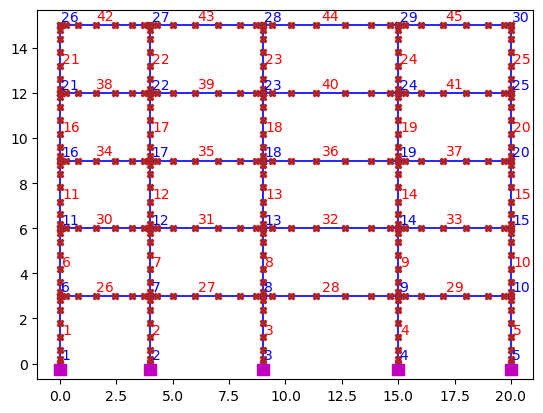

In [29]:
Lx1,Lx2,Lx3,Lx4 = 4,9,15,20    #input with reference to origin
Lz = 3
bays_length = [0.0,Lx1,Lx2,Lx3,Lx4] 
no_of_bays, no_of_floors= 4,5
total_nodes = len(bays_length)*(no_of_floors + 1)
build_model(Lx1,Lx2,Lx3,Lx4,Lz,no_of_bays, no_of_floors)
run_gravity()
run_modal(3)

# Modeshape Plot

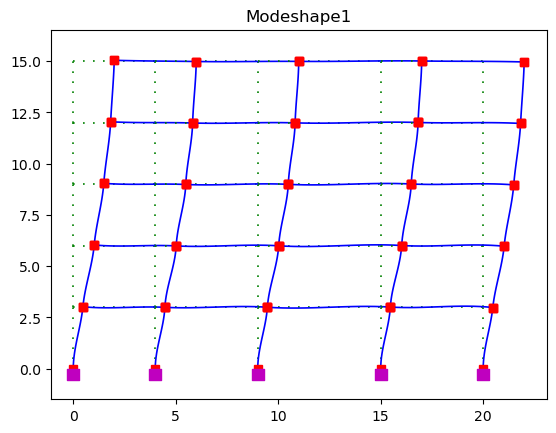

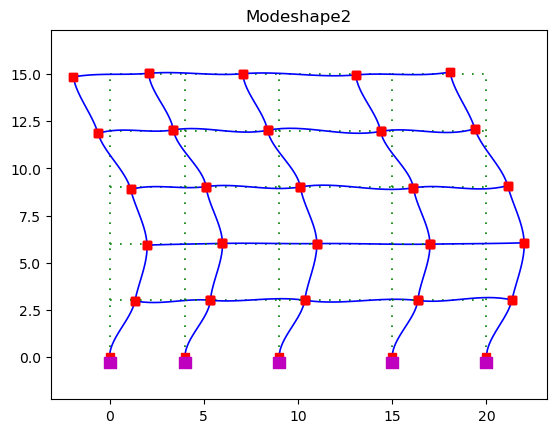

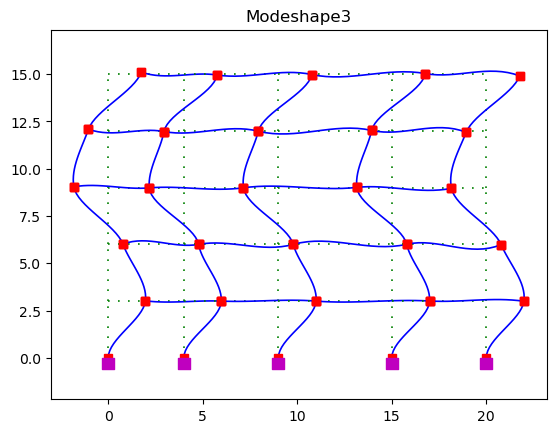

In [34]:
for i in range(1,4):
    ovs.plot_mode_shape(i)
    plt.title(f"Modeshape{i}")
    plt.show()

# Pushover Analysis

Gravity Analysis, Success!!!
Gravity Analysis Success in 0.65
Pushover Analysis in X-direction Done at  392.00 seconds


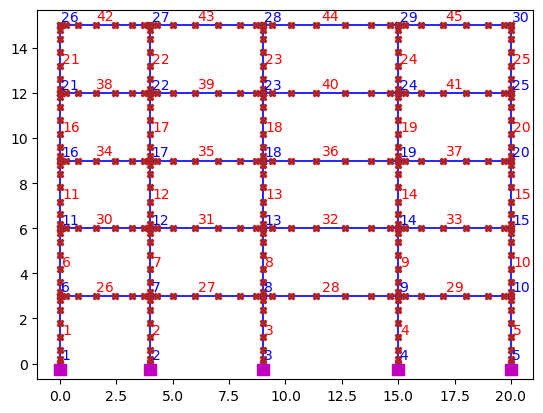

In [38]:
build_model(Lx1,Lx2, Lx3,Lx4, Lz,no_of_bays, no_of_floors)
run_gravity()
run_pushoverX()

# Pushover Curve Plot

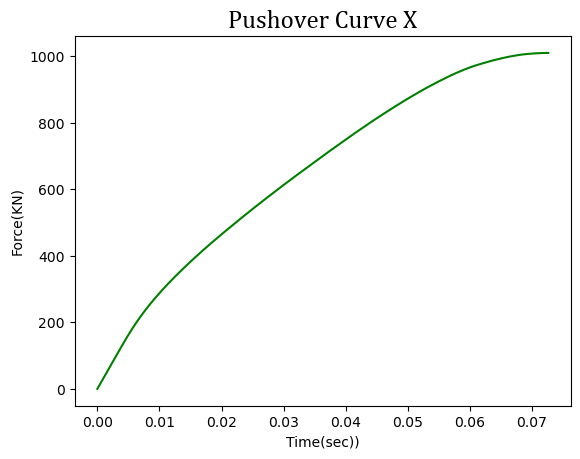

In [40]:
reacX = np.loadtxt(r"D:\Opensees\3D frame analysis\2d frame analysis\Pushover_Reaction.out", delimiter =' ')
dispX = np.loadtxt(r"D:\Opensees\3D frame analysis\2d frame analysis\Pushover_Displacement.out", delimiter =' ')
#Averaging the displacement for pushover curve 
avg_dispX = np.mean(dispX[:,1:total_nodes-no_of_bays],axis=1)
#Summing the Reaction for Pushover curve
sum_reacX = np.abs(np.sum(reacX[:,1:len(bays_length)+1],axis=1))
plt.xlabel("Time(sec))")
plt.ylabel("Force(KN)")
plt.title("Pushover Curve X", {'fontname':'Cambria', 'fontstyle':'normal','size':18})

plt.plot(avg_dispX,sum_reacX,color = "green")
plt.show()


In [42]:
len(avg_dispX)

10001

# Timehistory Analysis

Gravity Analysis, Success!!!
Gravity Analysis Success in 0.57
TimeHistory Analysis Succeed in X direction at time: 256.02 


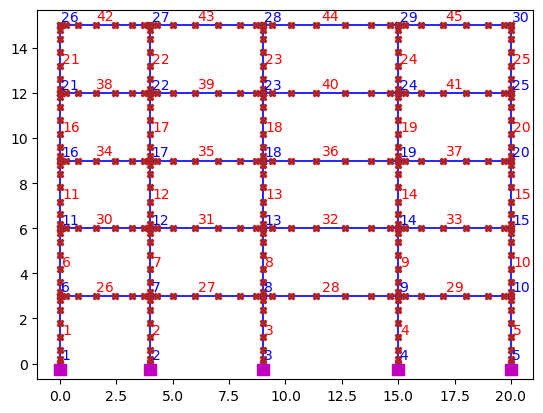

In [45]:
build_model(Lx1,Lx2, Lx3,Lx4, Lz,no_of_bays, no_of_floors)
run_gravity()
run_timehistory()

# Ground Motion Plot

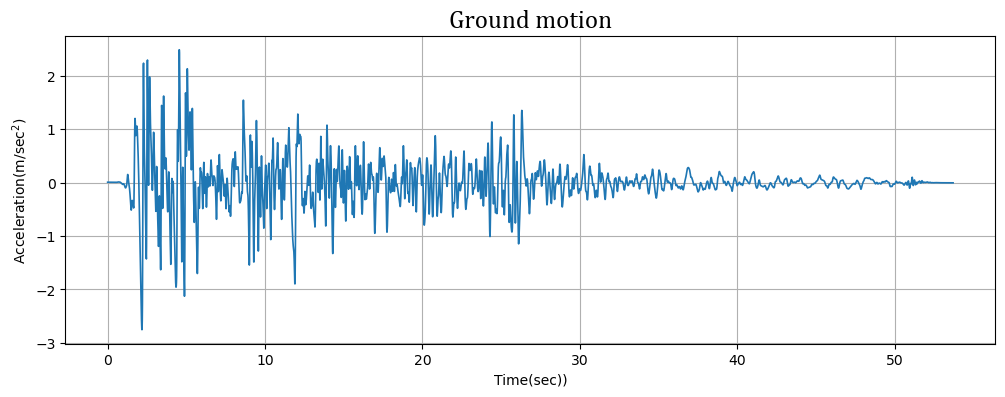

In [165]:
Ground_motion = ground_acc

plt.figure(figsize=(12,4))
plt.plot(np.arange(0,0.01*len(Ground_motion),0.01),Ground_motion[:],linewidth=1.2 )
plt.xlabel("Time(sec))")
plt.ylabel("Acceleration(m/sec$^2$)")
plt.title("Ground motion", {'fontname':'Cambria', 'fontstyle':'normal','size':18})
plt.grid()
plt.show()

# Outputs from Timehistory

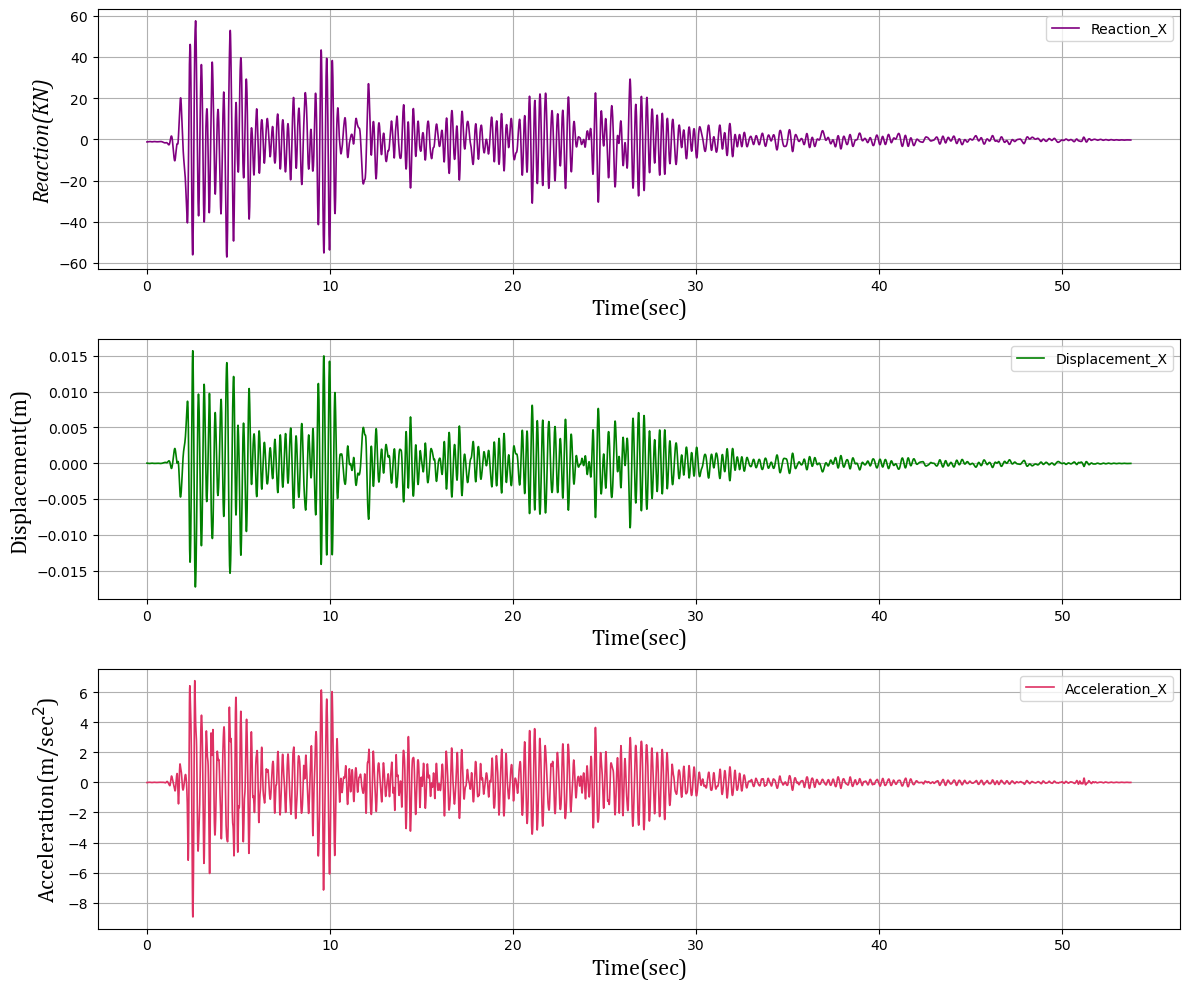

In [235]:
#X_Data
TH_Xdir_reac = np.loadtxt(r'D:\Opensees\3D frame Analysis\2d frame analysis\TimeHistory_Horizontal_ReactionX.out',delimiter=' ')
TH_Xdir_disp = np.loadtxt(r'D:\Opensees\3D frame Analysis\2d frame analysis\TimeHistory_Story_DisplacementX.out',delimiter=' ')
TH_Xdir_accl = np.loadtxt(r'D:\Opensees\3D frame Analysis\2d frame analysis\TimeHistory_Story_AccelerationX.out',delimiter=' ')

#plots
fig,ax= plt.subplots(3,figsize = (12,10))
ax[0].plot(TH_Xdir_reac[:,0],TH_Xdir_reac[:,-1],color = 'purple',linewidth = 1.2,label="Reaction_X")
ax[0].set_xlabel('Time(sec)',{'fontname':'Cambria', 'fontstyle':'normal','size':16})
ax[0].set_ylabel('Reaction(KN)',{'fontname':'Cambria', 'fontstyle':'italic','size':16})
ax[0].legend()

ax[1].plot(TH_Xdir_disp[:,0],TH_Xdir_disp[:,-1],color = 'green',linewidth = 1.2,label="Displacement_X")
ax[1].set_xlabel('Time(sec)',{'fontname':'Cambria', 'fontstyle':'normal','size':16})
ax[1].set_ylabel('Displacement(m)',{'fontname':'Cambria', 'fontstyle':'normal','size':16})
ax[1].legend()
ax[2].plot(TH_Xdir_accl[:,0],TH_Xdir_accl[:,-1],color = '#DE3163',linewidth = 1.2, label="Acceleration_X")
ax[2].set_xlabel('Time(sec)',{'fontname':'Cambria', 'fontstyle':'normal','size':16})
ax[2].set_ylabel('Acceleration(m/sec$^2$)',{'fontname':'Cambria', 'fontstyle':'normal','size':16})
ax[2].legend()

for i in range(3):
    ax[i].grid(True)
    
plt.tight_layout()
plt.show()

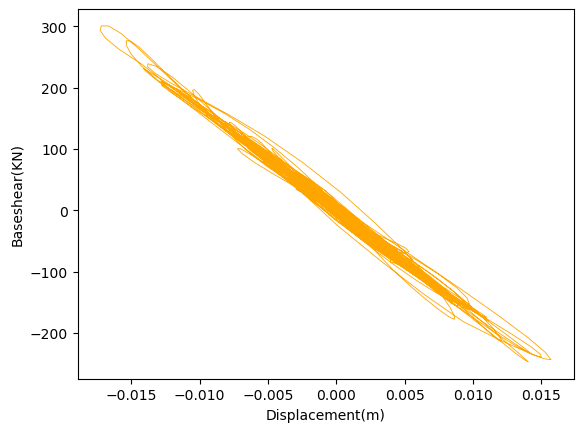

In [232]:
BaseShear = np.sum(TH_Xdir_reac[:,1:len(bays_length)], axis=1)
Avg_top_disp = np.mean(TH_Xdir_disp[:,total_nodes-no_of_bays:total_nodes],axis = 1)
plt.plot(Avg_top_disp,BaseShear,color = 'orange',linewidth = 0.6)
plt.xlabel("Displacement(m)")
plt.ylabel("Baseshear(KN)")
plt.show()

In [209]:
el_tags = op.getEleTags()
print(el_tags)
nels = len(el_tags)

    

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]


In [211]:
data = np.loadtxt(r'D:\Opensees\3D frame analysis\2d frame analysis\TimeHistory_Story_DisplacementX.out', delimiter = ' ')

In [213]:
n_steps=len(data)
node_disps = data[:,1:]
node_disps

array([[ 0.00000e+00,  0.00000e+00,  0.00000e+00, ...,  5.35131e-06,
         3.12136e-07, -2.71120e-06],
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00, ...,  4.36960e-06,
        -6.69589e-07, -3.69297e-06],
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00, ...,  2.40550e-06,
        -2.63374e-06, -5.65724e-06],
       ...,
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00, ..., -2.70808e-05,
        -3.25367e-05, -3.57990e-05],
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00, ..., -2.97221e-05,
        -3.51783e-05, -3.84407e-05],
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00, ..., -3.26226e-05,
        -3.80793e-05, -4.13418e-05]])

In [56]:
# Eds = np.zeros((n_steps,nels, 6))
# timeV = data[:, 0]

# # transient analysis loop and collecting the data
# for step in range(n_steps):
#     # collect disp for element nodes
#     for el_i, ele_tag in enumerate(el_tags):
#         nd1, nd2 = op.eleNodes(ele_tag)
#         Eds[step, el_i, :] = [node_disps[step][nd1-1],
#                               0,
#                               0,
#                               node_disps[step][nd2-1],
#                              0,
#                              0]

In [52]:
# fmt_defo = {'color': 'blue', 'linestyle': 'solid', 'linewidth': 3.0,
#             'marker': '', 'markersize': 6}

# # 1. animate the deformated shape
# anim = ovs.anim_defo(Eds, timeV, 400, fmt_defo=fmt_defo, xlim=[-18, 35], ylim=[-1, 17], fig_wi_he=(30., 22.))
# HTML(anim.to_jshtml())

In [54]:
# # 2. after closing the window, animate the specified mode shape
# eigVals = op.eigen(3)

# modeNo = 3  # specify which mode to animate
# f_modeNo = np.sqrt(eigVals[modeNo-1])/(2*np.pi)  # i-th natural frequency

# anim = ovs.anim_mode(modeNo, fmt_defo=fmt_defo,
#                       xlim=[-8, 25], ylim=[-1, 17], fig_wi_he=(30., 22.))
# plt.title(f'Mode {modeNo}, f_{modeNo}: {f_modeNo:.3f} Hz')
# HTML(anim.to_jshtml())